In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


In [2]:
def submit_for_score(model):
    test_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

    # Applying Date Transformer before preprocessing
    #date_cols = ['DateAS', 'DateOS']
    #date_transformer = DateTransformer(date_columns=date_cols)
    #test_df = date_transformer.transform(test_df)

    X_test = test_df.drop(columns=['target'], errors='ignore')
    X_test_processed = preprocessor.transform(X_test)

    # predictions
    pred = model.predict(X_test_processed)

    # submission file
    submission = pd.DataFrame({"id": range(0, X_test.shape[0]), "target": pred})
    submission.to_csv('submission.csv', index=False)

# **Importing Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report

# **1. Data Loading**

In [4]:
train_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

train_df.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


# **2. Exploratory Data Analysis**

**Data Types and missing values of columns**

In [5]:
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

Train dataset shape: (100000, 76)
Test dataset shape: (10000, 75)


In [6]:
# Displaying column data types and missing values
print("\nColumn Data Types:")
print(train_df.dtypes)

print("\nMissing Values in Train Dataset:")
null_summary1 = train_df.isnull().sum()[train_df.isnull().sum() > 0].to_frame(name='Null Count')
null_summary1['Null Percentage (%)'] = (train_df.isna().sum() / len(train_df)) * 100
print(null_summary1)

print("\nMissing Values in Test Dataset:")
null_summary2 = test_df.isnull().sum()[test_df.isnull().sum() > 0].to_frame(name='Null Count')
null_summary2['Null Percentage (%)'] = (test_df.isna().sum() / len(test_df)) * 100
print(null_summary2)


Column Data Types:
MachineID            object
ProductName          object
EngineVersion        object
AppVersion           object
SignatureVersion     object
                     ...   
IsGamer             float64
RegionIdentifier    float64
DateAS               object
DateOS               object
target                int64
Length: 76, dtype: object

Missing Values in Train Dataset:
                                    Null Count  Null Percentage (%)
RealTimeProtectionState                     66                0.066
AntivirusConfigID                           76                0.076
NumAntivirusProductsInstalled               76                0.076
NumAntivirusProductsEnabled                 76                0.076
CityID                                     623                0.623
IsSystemProtected                           76                0.076
SMode                                      981                0.981
IEVersionID                                107                0.107


***Insights from data***
* Column 'SMode' has the highest Null Count Percentage (most number of missing values)
* Column 'ChassisType' has the least Null Count Percentage ( apart from columns having no missing values)

**Checking unique values in categorical columns**

In [7]:
cat_cols = train_df.select_dtypes(include=['object']).columns
train_df[cat_cols].nunique().sort_values(ascending=False)

MachineID                   99835
SignatureVersion             2735
DateAS                       2695
OSBuildLab                    281
NumericOSVersion              221
DateOS                        112
AppVersion                     69
EngineVersion                  37
ChassisType                    28
OSEdition                      20
OSSkuFriendlyName              18
OSBranch                       13
MDC2FormFactor                 11
OSInstallType                   9
PowerPlatformRole               9
OsPlatformSubRelease            9
SKUEditionName                  8
FlightRing                      7
OSVersion                       7
LicenseActivationChannel        6
AutoUpdateOptionsName           6
PrimaryDiskType                 4
PlatformType                    4
OSGenuineState                  4
Processor                       3
OSArchitecture                  3
ProductName                     2
DeviceFamily                    2
dtype: int64


***Insights from data***
* Column 'MachineID' has the highest number of Unique values (99835)
* Column 'DateAS' has too many values and hence we can build a date transformer under feature engineering.
* Column 'ProductName' and 'DeviceFamily' has the least number of Unique values (2)

**Numerical columns and their statistics**

In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
IsBetaUser,100000.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00
RealTimeProtectionState,99934.0,6.848430e+00,1.015166e+00,0.0,7.0,7.0,7.000000e+00,8.000000e+00
IsPassiveModeEnabled,100000.0,1.762000e-02,1.315664e-01,0.0,0.0,0.0,0.000000e+00,1.000000e+00
AntivirusConfigID,99924.0,4.797571e+04,1.380332e+04,39.0,49480.0,53447.0,5.344700e+04,7.049000e+04
NumAntivirusProductsInstalled,99924.0,1.326528e+00,5.206814e-01,1.0,1.0,1.0,2.000000e+00,5.000000e+00
NumAntivirusProductsEnabled,99924.0,1.018264e+00,1.552909e-01,0.0,1.0,1.0,1.000000e+00,4.000000e+00
HasTpm,100000.0,9.967800e-01,5.665389e-02,0.0,1.0,1.0,1.000000e+00,1.000000e+00
CountryID,100000.0,1.080788e+02,6.306215e+01,1.0,51.0,97.0,1.620000e+02,2.220000e+02
CityID,99377.0,8.102994e+04,4.894403e+04,7.0,36694.0,82373.0,1.228350e+05,1.679570e+05
GeoRegionID,100000.0,1.697416e+02,8.918893e+01,1.0,89.0,181.0,2.670000e+02,2.960000e+02


**Feature distribution of Categorical Columns**

Categorical Feature Summary (Top 10 Shown)
              Feature  Unique Categories  Top Value %
8        DeviceFamily                  2        99.97
0         ProductName                  2        99.77
4           OSVersion                  7        98.37
2        PlatformType                  4        98.34
20         FlightRing                  7        94.15
12     OSArchitecture                  3        91.28
3           Processor                  3        91.26
18     OSGenuineState                  4        89.86
11  PowerPlatformRole                  9        69.87
9     PrimaryDiskType                  4        66.22

 High Cardinality Columns (>10 categories): ['MDC2FormFactor', 'ChassisType', 'OSBranch', 'EngineVersion', 'OSEdition', 'OSSkuFriendlyName']


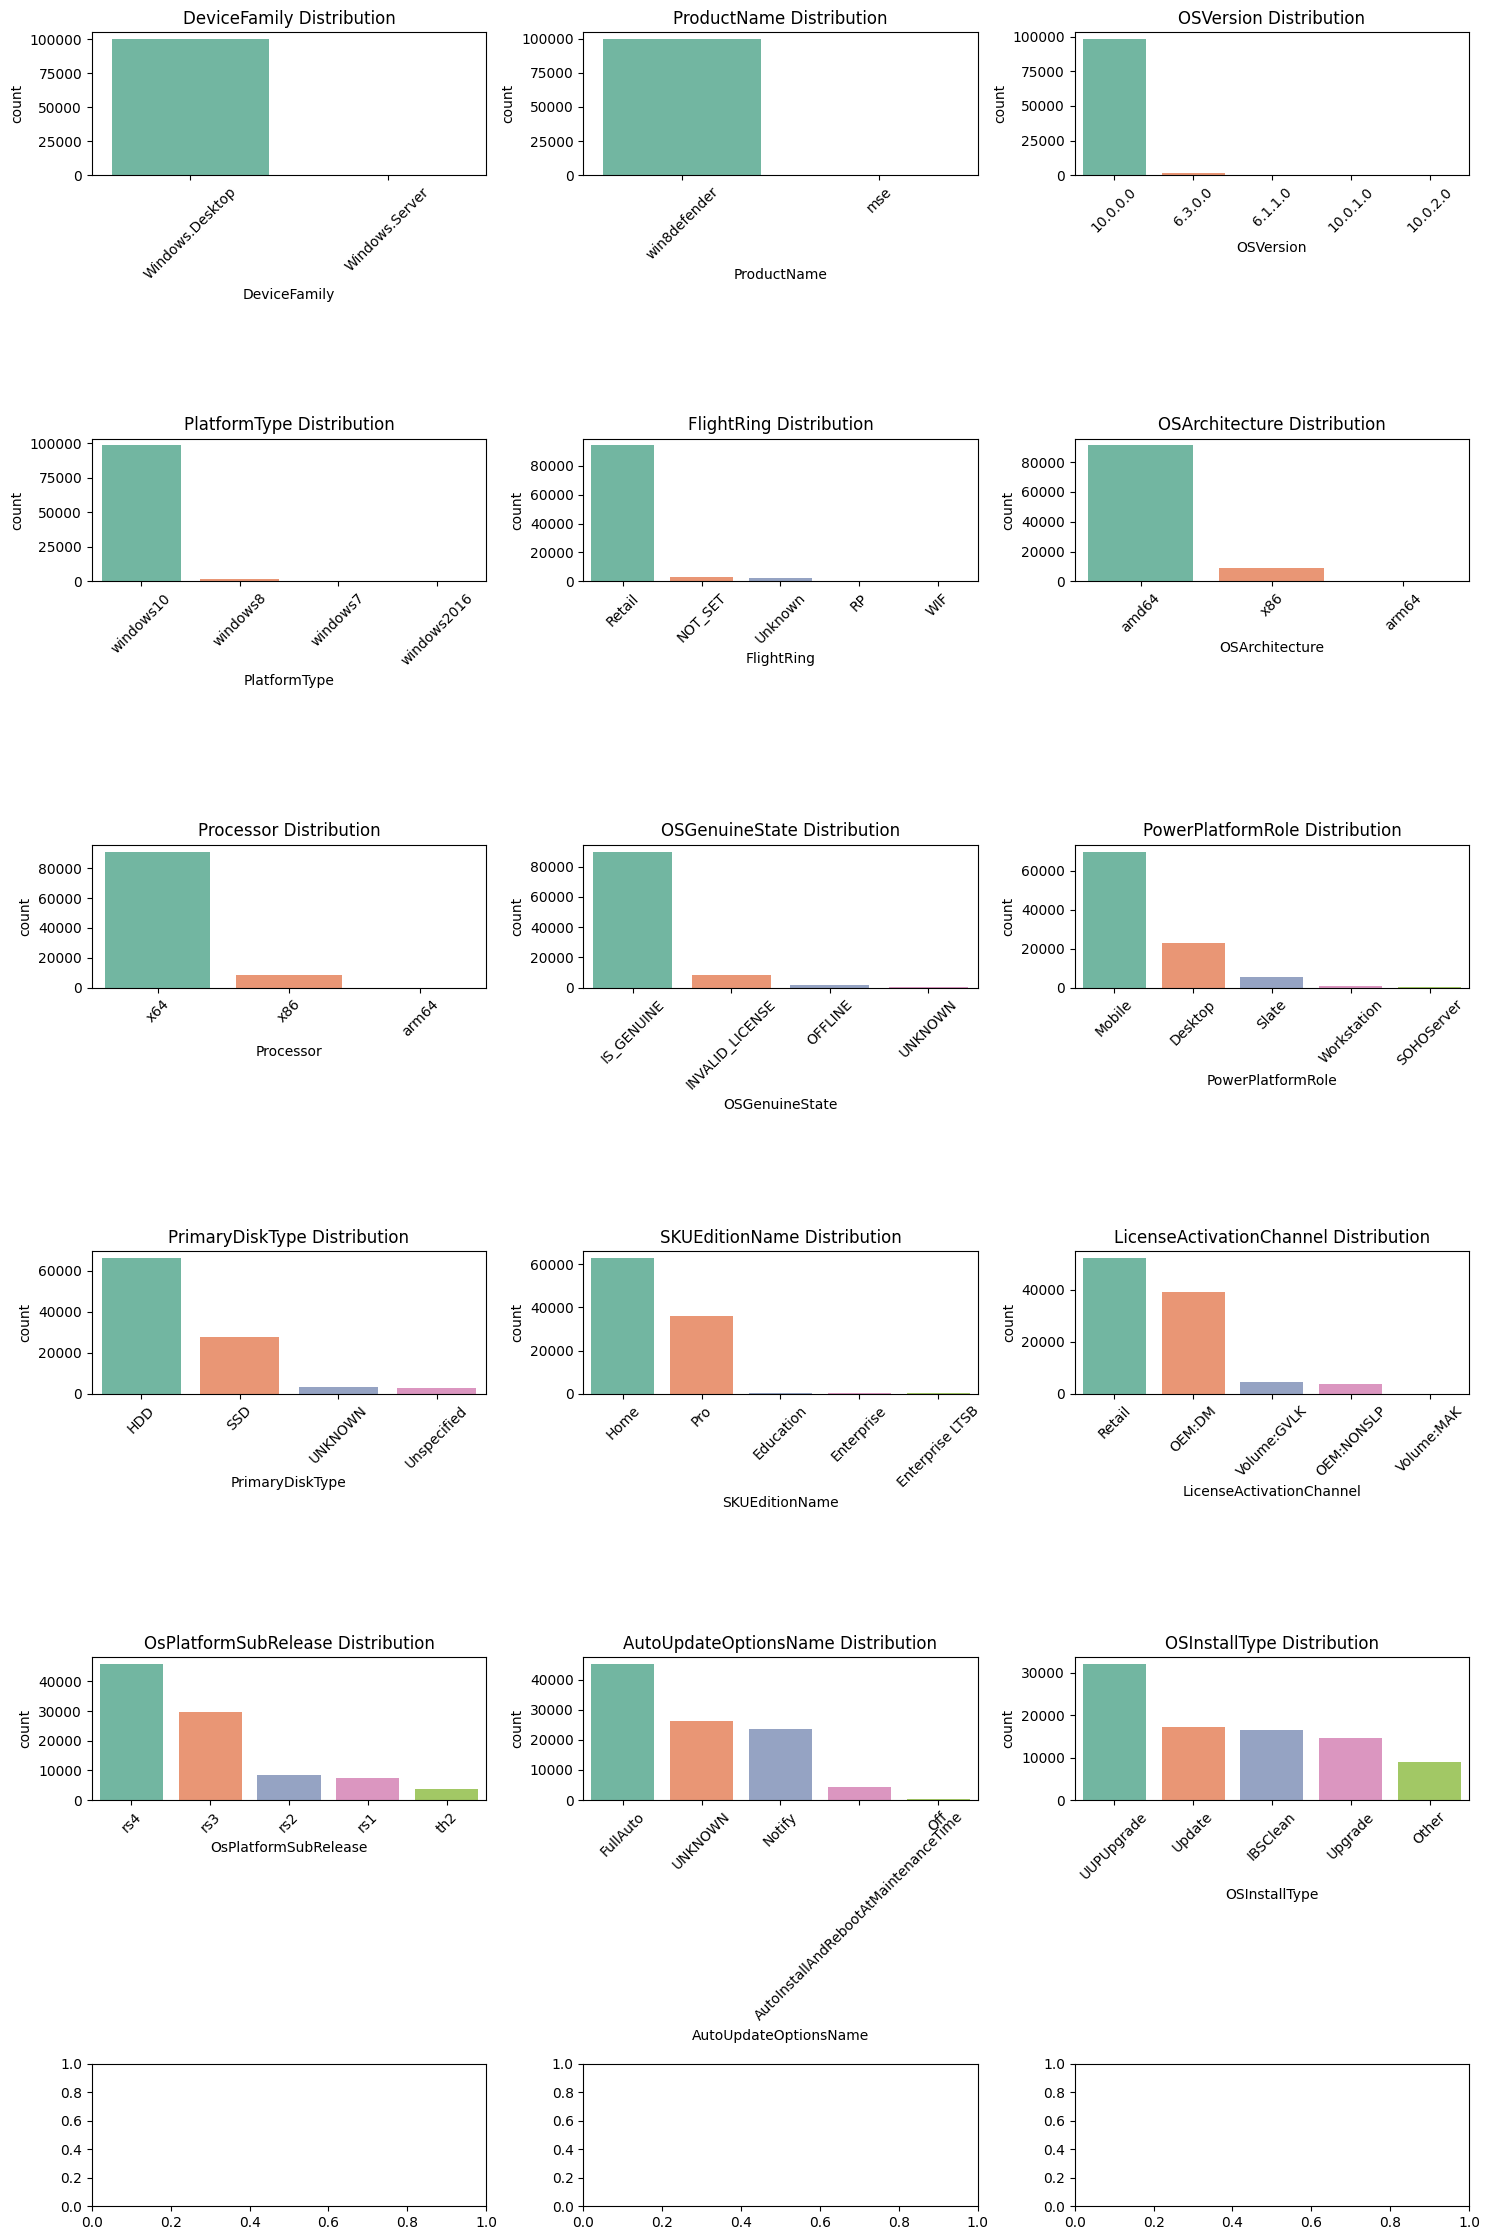

In [9]:
cat_cols = train_df.select_dtypes(include=['object']).columns

# Value Counts (Excluding High-Cardinality Features)
summary_data = []

for col in cat_cols:
    unique_count = train_df[col].nunique()
    if unique_count > 50:  
        continue

    top_value = train_df[col].value_counts(normalize=True).values[0] * 100

    summary_data.append([col, unique_count, round(top_value, 2)])

summary_df = pd.DataFrame(summary_data, columns=["Feature", "Unique Categories", "Top Value %"])


summary_df = summary_df.sort_values(by="Top Value %", ascending=False)

print("Categorical Feature Summary (Top 10 Shown)")
print(summary_df.head(10))

# High Cardinality Detection
high_cardinality_cols = summary_df[summary_df["Unique Categories"] > 10]["Feature"].tolist()
print(f"\n High Cardinality Columns (>10 categories): {high_cardinality_cols}")

# smaller visualizations (Top 5 values for low-cardinality columns)
low_cardinality_cols = summary_df[summary_df["Unique Categories"] <= 10]["Feature"].tolist()

num_plots = min(len(low_cardinality_cols), 15)
fig, axes = plt.subplots(nrows=(num_plots // 3) + 1, ncols=3, figsize=(15, num_plots * 1.5))

for i, col in enumerate(low_cardinality_cols[:num_plots]):
    ax = axes[i // 3, i % 3]
    sns.countplot(data=train_df, x=col, order=train_df[col].value_counts().index[:5], palette='Set2', ax=ax)
    ax.set_title(f"{col} Distribution")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Target Variable Analysis**

Target Variable Distribution
target
1    50525
0    49475
Name: count, dtype: int64

 Target Variable Distribution (Percentage)
target
1    50.525
0    49.475
Name: proportion, dtype: float64


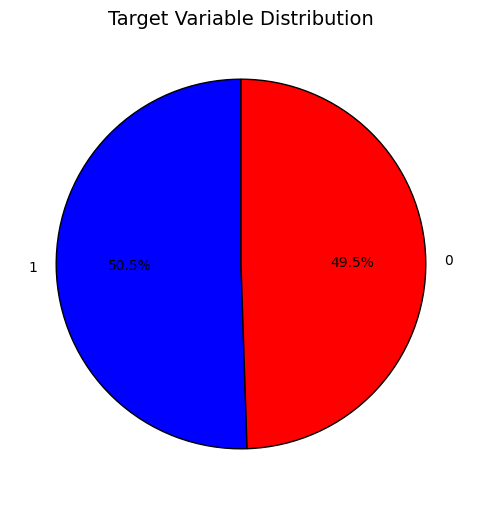

In [10]:
print("Target Variable Distribution")
print(train_df['target'].value_counts())
print("\n Target Variable Distribution (Percentage)")
print(train_df['target'].value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 6))
train_df['target'].value_counts().plot.pie(
    autopct="%1.1f%%", 
    colors=["blue", "red"], 
    startangle=90, 
    wedgeprops={"edgecolor": "black"}
)

plt.title("Target Variable Distribution", fontsize=14)
plt.ylabel("")
plt.show()

* ***The dataset seems very balanced, with 50.5% of the target variable being '1' and only 49.5% being '0'***

**Distribution of Numeric Categories**

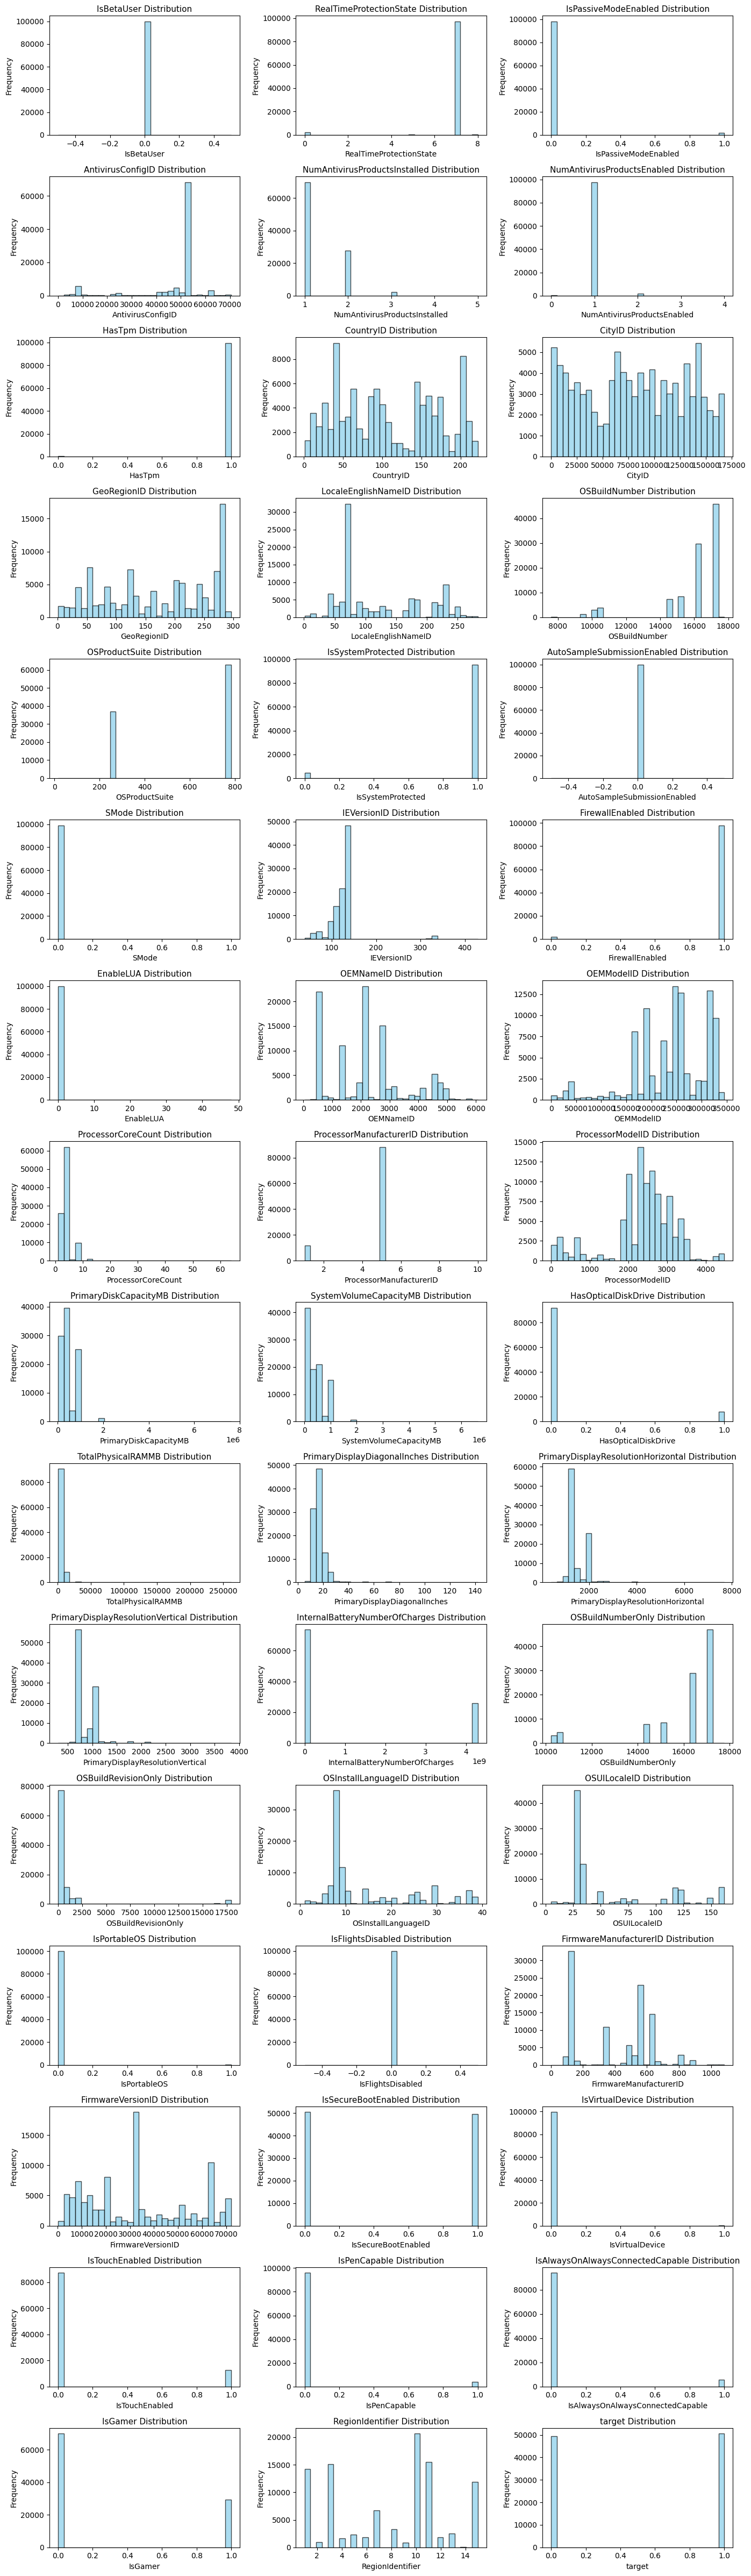

In [11]:
import matplotlib.pyplot as plt

num_columns = train_df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# grid layout
n_cols = 3  
n_rows = (len(num_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(num_columns):
    axes[i].hist(train_df[col].dropna(), bins=30, color="skyblue", edgecolor="black", alpha=0.7)
    axes[i].set_title(f"{col} Distribution", fontsize=11, pad=5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Pie Chart for Distribution of Categorical Features**

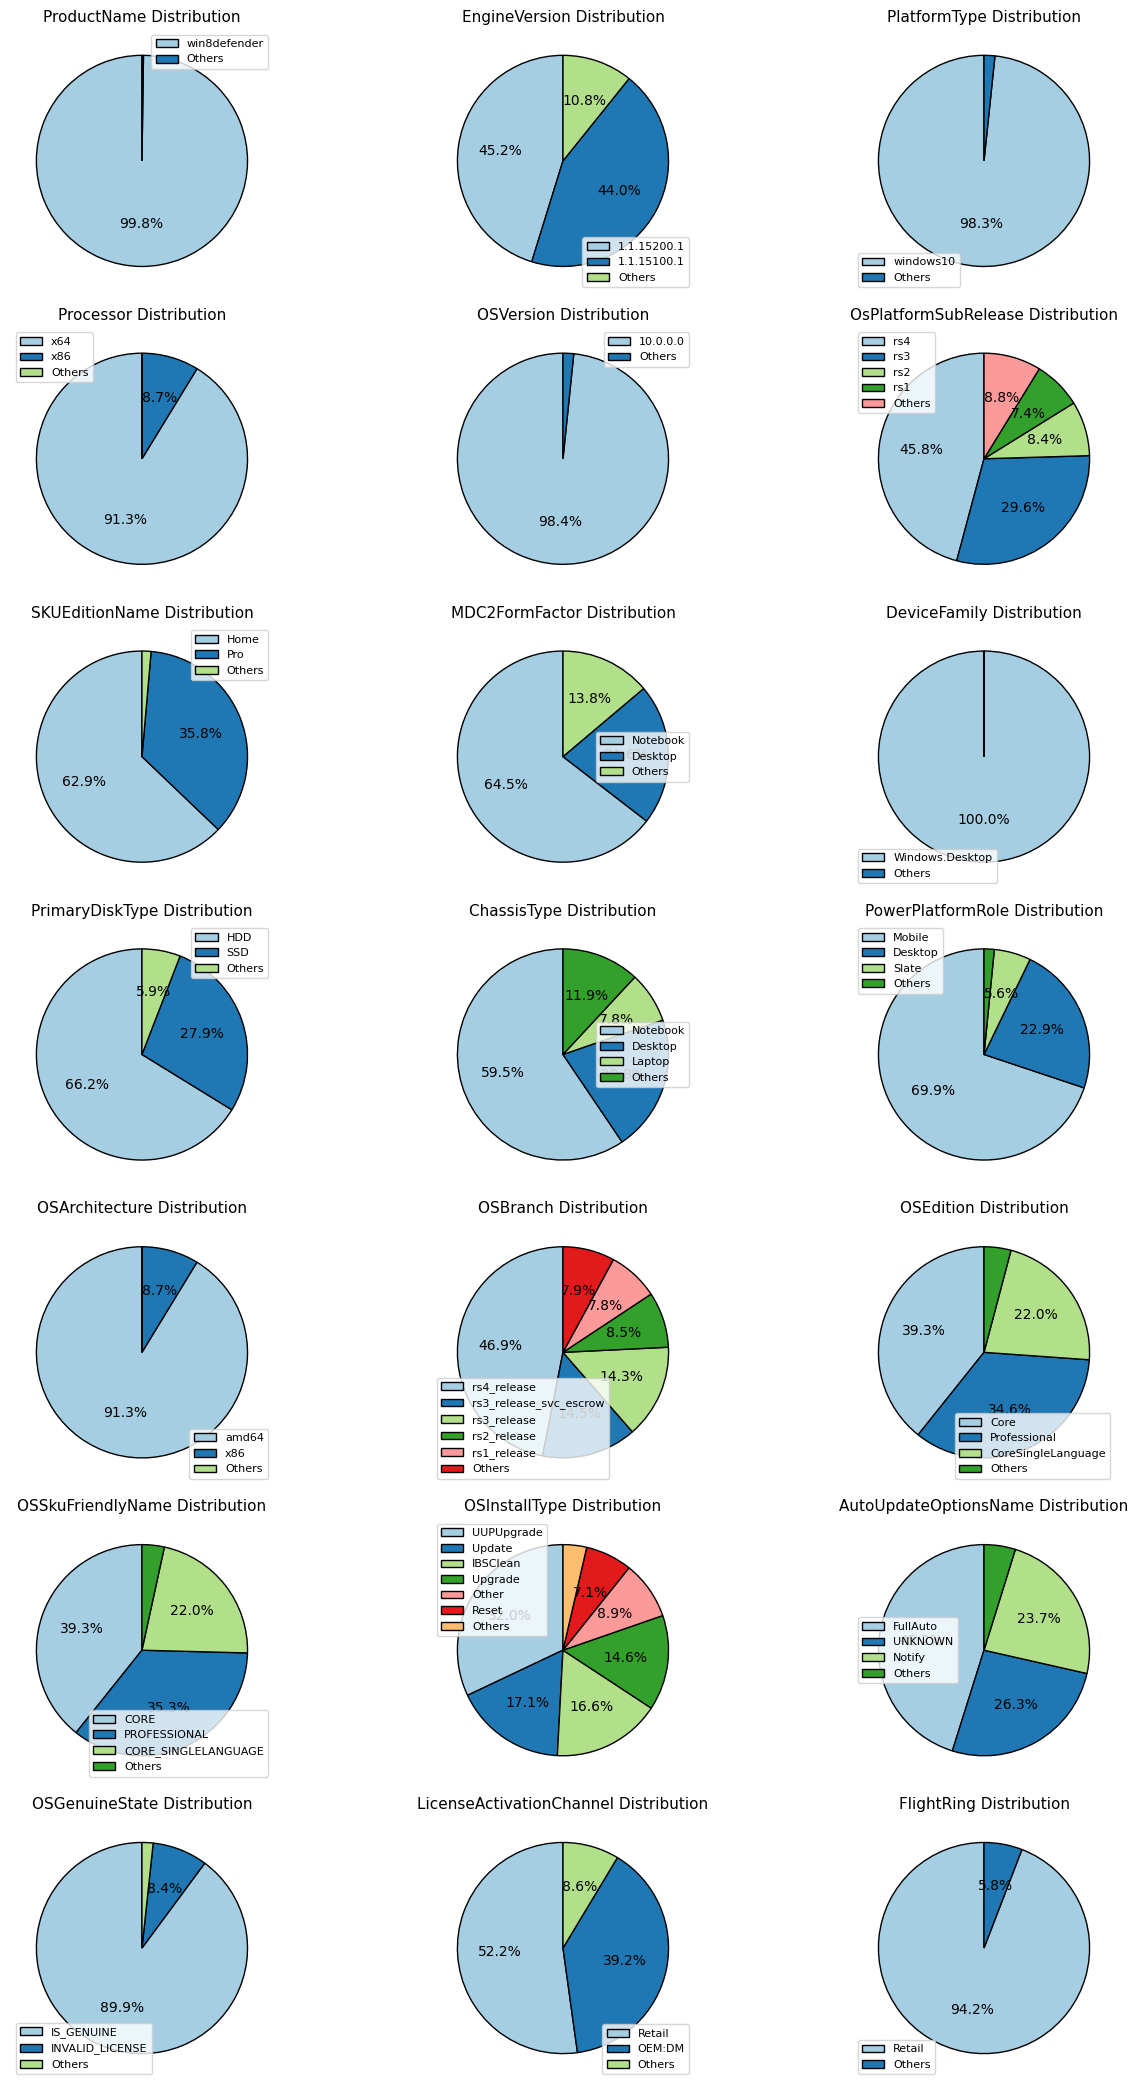

In [12]:
# Detecting categorical columns with low cardinality
cat_columns = train_df.select_dtypes(include=["object", "category"]).columns.tolist()
low_cardinality_cols = [col for col in cat_columns if train_df[col].nunique() <= 50]

# grid layout
n_cols = 3  
n_rows = (len(low_cardinality_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(low_cardinality_cols):
    counts = train_df[col].value_counts(normalize=True)
    
    # Merging small categories (<5%) into "Others"
    small_threshold = 0.05
    large_categories = counts[counts >= small_threshold]
    small_categories_sum = counts[counts < small_threshold].sum()
    
    if small_categories_sum > 0:
        large_categories["Others"] = small_categories_sum
    
    # pie chart
    wedges, texts, autotexts = axes[i].pie(
        large_categories, labels=None, autopct=lambda p: f'{p:.1f}%' if p > 5 else '',
        startangle=90, colors=plt.cm.Paired.colors, wedgeprops={"edgecolor": "black", "linewidth": 1}
    )
    
    axes[i].set_title(f"{col} Distribution", fontsize=11, pad=5)
    axes[i].legend(large_categories.index, loc="best", fontsize=8)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# **3.Feature Engineering / Data Pre-Processing**

In [13]:
#from sklearn.base import BaseEstimator, TransformerMixin

#class DateTransformer(BaseEstimator, TransformerMixin):
#    def __init__(self, date_columns=None):
#        self.date_columns = date_columns if date_columns else []
    
#    def fit(self, X, y=None):
#        return self

#    def transform(self, X):
#        X = X.copy()
        
#        for col in self.date_columns:
#            if col == 'DateAS':
                # Converting 'DateAS' format: 'YYYY-MM-DD HH:MM:SS' (Datetime with Time)
#                X[col] = pd.to_datetime(X[col], format='%Y-%m-%d %H:%M:%S', errors='coerce')
#            elif col == 'DateOS':
                # Converting 'DateOS' format: 'YYYY-MM-DD' (Date Only)
#                X[col] = pd.to_datetime(X[col], format='%Y-%m-%d', errors='coerce')

            # Extracting year,day,month,etc.
#            X[f'{col}_Year'] = X[col].dt.year
#            X[f'{col}_Month'] = X[col].dt.month
#            X[f'{col}_Day'] = X[col].dt.day
#            X[f'{col}_Weekday'] = X[col].dt.weekday  # 0 = Monday

            # Time since earliest date in dataset
#            X[f'{col}_ElapsedDays'] = (X[col] - X[col].min()).dt.days

#            X.drop(columns=[col], inplace=True)
        
#        return X


In [14]:
#date_cols = ['DateAS', 'DateOS']  # Date columns
#date_transformer = DateTransformer(date_columns=date_cols)

# Applying transformation
#train_df = date_transformer.fit_transform(train_df)
#test_df = date_transformer.transform(test_df)

#print(train_df.head())

**Seperating Target Column**

In [15]:
X = train_df.drop(columns=['target'])
y = train_df['target']

**Train-Validation Split**

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#'stratify=y' ensures class balance in train & validation splits.

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")

Training set size: 80000 samples
Validation set size: 20000 samples


**Identify Numeric and Categorical Columns**

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Numerical and categorical columns
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [18]:
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handling the missing values
    ('scaler', StandardScaler())  # Normalizing data
])

# Pipeline for categorical features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handling the missing values
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encoding categorical features
])

# Combining both pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print("Missing values in X_train_processed:", np.sum(pd.isna(X_train_processed)))
print("Missing values in X_val_processed:", np.sum(pd.isna(X_val_processed)))

Missing values in X_train_processed: 0
Missing values in X_val_processed: 0


# **4. Model Building**

**4a. Logestic Regression**

In [19]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=2000, random_state=42)
log_reg.fit(X_train_processed, y_train)
y_val_pred = log_reg.predict(X_val_processed)

#model performance
acc = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)

print(f"Logistic Regression - Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")
print("\nClassification Report:\n", report)

Logistic Regression - Accuracy: 0.6122, F1-Score: 0.6332

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59      9895
           1       0.61      0.66      0.63     10105

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000



In [20]:
#submit_for_score(log_reg))

**4b. Decision Tree Classifier**

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_processed, y_train)
y_val_pred = dt_model.predict(X_val_processed)

dt_accuracy = accuracy_score(y_val, y_val_pred)
dt_report = classification_report(y_val, y_val_pred)

print(f"Decision Tree - Accuracy: {dt_accuracy:.4f}")
print("\nClassification Report:\n", dt_report)

Decision Tree - Accuracy: 0.5568

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.55      0.55      9895
           1       0.56      0.57      0.56     10105

    accuracy                           0.56     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.56      0.56      0.56     20000



In [22]:
#submit_for_score(dt_model)

**4c. Random Forest Classifier**

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train_processed, y_train)
y_val_pred = rf_model.predict(X_val_processed)

rf_accuracy = accuracy_score(y_val, y_val_pred)
rf_report = classification_report(y_val, y_val_pred)

print(f"Random Forest - Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:\n", rf_report)

Random Forest - Accuracy: 0.6064

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.57      0.59      9895
           1       0.60      0.64      0.62     10105

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000



In [24]:
#submit_for_score(rf_model)

**4d. XGBoost**

In [25]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_processed, y_train)
y_val_pred = xgb_model.predict(X_val_processed)

xgb_accuracy = accuracy_score(y_val, y_val_pred)
xgb_report = classification_report(y_val, y_val_pred)

print(f"XGBoost - Accuracy: {xgb_accuracy:.4f}")
print("\nClassification Report:\n", xgb_report)

XGBoost - Accuracy: 0.6254

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.58      0.61      9895
           1       0.62      0.67      0.64     10105

    accuracy                           0.63     20000
   macro avg       0.63      0.62      0.62     20000
weighted avg       0.63      0.63      0.62     20000



In [26]:
#submit_for_score(xgb_model)

**4e. LightGBM**

In [27]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_model.fit(X_train_processed, y_train)
y_val_pred = lgbm_model.predict(X_val_processed)

accuracy = accuracy_score(y_val, y_val_pred)
print("LightGBM - Accuracy:", round(accuracy, 4))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

[LightGBM] [Info] Number of positive: 40420, number of negative: 39580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.469955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7982
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 2247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001
LightGBM - Accuracy: 0.6287

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.59      0.61      9895
           1       0.62      0.67      0.65     10105

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



In [28]:
#submit_for_score(lgbm_model)

## Model Performance Comparison

| Model               | Accuracy | F1-Score (Class 1) | F1-Score (Class 0) | Precision (Class 1) | Precision (Class 0) | Recall (Class 1) | Recall (Class 0) |
|---------------------|----------|--------------------|---------------------|----------------------|---------------------|------------------|------------------|
| **Logistic Regression** | 0.6122 | 0.6332 | 0.59 | 0.61 | 0.62 | 0.66 | 0.56 |
| **Decision Tree**      | 0.5568  | 0.56   | 0.55 | 0.56  | 0.55 | 0.57  | 0.55 |
| **Random Forest**       | 0.6064  | 0.62   | 0.59 | 0.60  | 0.61 | 0.64  | 0.57 |
| **XGBoost**            | 0.6254 | 0.64 | 0.61 | 0.62  | 0.63 | 0.67 | 0.58 |
| **LightGBM**           | 0.6287 | 0.65 | 0.61 | 0.62  | 0.64 | 0.67 | 0.59|

**Key Observations**
* Decision Tree performed the worst with the lowest accuracy (0.5568)
* Logistic Regression performed slightly better than Random Forest but still not the best choice.
* XGBoost and LightGBM had the best performance in terms of accuracy (0.63) and F1-score (0.64-0.65), showing better generalization.
* LightGBM slightly outperformed XGBoost in accuracy and recall, making it a strong candidate.




**XGBoost and LightGBM** gave the best result
* Higher Performance: Both models achieved the highest accuracy and F1-scores, meaning they generalize better on unseen data.
* Better Recall: XGBoost and LightGBM had the highest recall for Class 1 (~0.67), making them ideal when missing positive cases is costly.
* Scalability: LightGBM handles large datasets efficiently due to its histogram-based learning.

# **5. HyperParameter Tuning**

**5a. XGBoost HPT**

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# parameter grid
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Randomized search
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=10, 
    scoring='f1', cv=3, verbose=2, n_jobs=-1
)

random_search.fit(X_train_processed, y_train)

best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Training final XGBoost model with best parameters
best_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb.fit(X_train_processed, y_train)

y_val_pred = best_xgb.predict(X_val_processed)

print("Optimized XGBoost Model Performance:")
print(classification_report(y_val, y_val_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Optimized XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.64      0.54      0.59      9895
           1       0.61      0.70      0.65     10105

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



In [30]:
submit_for_score(best_xgb)

**5b. LightGBM HPT**

In [31]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

# parameter grid
param_dist = {
    'num_leaves': [20, 31, 40, 50],
    'max_depth': [5, 10, 15, -1],  # -1 means no limit
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [200, 500, 1000],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

lgb_model = lgb.LGBMClassifier()

#Randomized Search
random_search = RandomizedSearchCV(
    estimator=lgb_model, 
    param_distributions=param_dist, 
    n_iter=10,  # Number of different parameter combinations to try
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train_processed, y_train)

print("Best Parameters:", random_search.best_params_)

# Evaluating the best model
best_lgbm_model = random_search.best_estimator_
y_pred = best_lgbm_model.predict(X_val_processed)

print("Optimized LightGBM Model Performance:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 40420, number of negative: 39580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.484170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7982
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 2247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001
Best Parameters: {'subsample': 0.9, 'num_leaves': 40, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Optimized LightGBM Model Performance:
Accuracy: 0.626
              precision    recall  f1-score   support

           0       0.63      0.59      0.61      9895
           1       0.62      0.66      0.64     10105

    accuracy                           0.63     20000
   macro avg       0.63      0

In [32]:
#submit_for_score(best_lgbm_model)